# NLP- Disaster Tweets

### 1. Import Libraries

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm  import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

### 2. Load Dataset

In [2]:
train_data=pd.read_csv('train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_data.shape

(7613, 5)

In [4]:
test_data=pd.read_csv('test.csv')
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
test_data.shape

(3263, 4)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
train_data.duplicated().sum()

0

- Showing unique values and number of unique values in each column

In [58]:
train_data.nunique()

text            7503
target             2
cleaned_text    7467
dtype: int64

-  Show Distribution of 2 Values in target Column

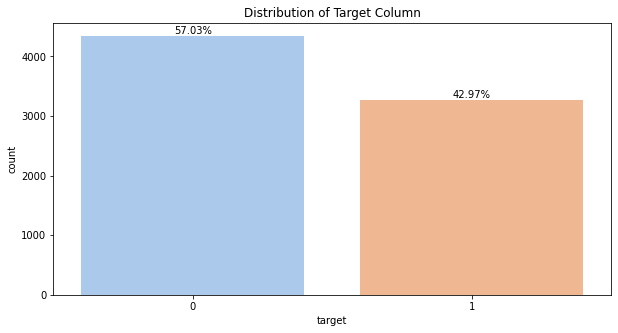

In [10]:

plt.figure(figsize=(10,5))
ax=sns.countplot(x='target',data=train_data,palette='pastel')
plt.title('Distribution of Target Column')

total = len(train_data['target'])
for p in ax.patches:
    height = p.get_height()  # Get the height of each bar
    percentage = f'{100 * height / total:.2f}%'  # Calculate percentage
    ax.annotate(percentage,                      # The text to display
                (p.get_x() + p.get_width() / 2., height),  # Position the text
                ha='center', va='bottom')        # Center it

plt.show()

-  Checking and Handling missing Values

In [11]:

train_data.isna().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

- Observation:

- There are null values in 2 columns keyword,location.

In [13]:
# Show Percentage of null values in keyword,location

train_data['location'].isna().sum()/train_data.shape[0]*100

33.27203467752528

In [14]:
train_data['keyword'].isna().sum()/train_data.shape[0]*100

0.8012610009194797

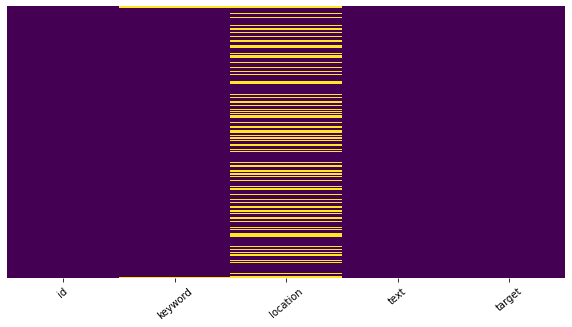

In [15]:
# Visualization of Null values

plt.figure(figsize=(10,5))
sns.heatmap(data=train_data.isna(),yticklabels=False,cbar=False,cmap='viridis')
plt.xticks(rotation=40)
plt.show()

- Observation:
- As id Column isn't usefull at all,I will drop it.

- Location Column has 33.27 % Null value,So I decided to drop it.

- keyword Column which has 0.8 % Null value and It includs only one word from tweet,So I see it's useless and I decided to remove it.

- The main aim is to classify tweet if's disaster or not,So I will keep only 2 columns which represents this problem: text,target.

In [16]:
train_data.drop(columns='id',inplace=True)

In [17]:
train_data.drop(columns=['location','keyword'],inplace=True)

In [18]:
train_data

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [19]:
# Check for Null Values and Duplicated Rows After Removing id,keyword,location Columns

train_data.isna().sum()


text      0
target    0
dtype: int64

In [20]:
train_data.duplicated().sum()

92

- We observe that:
1. There isn't any null value in 2 columns.

2. There are 92 duplicated rows,So we must drop them all.

In [21]:
train_data.drop_duplicates(inplace=True)

In [22]:
# Checking that duplicates are removed

train_data.duplicated().sum()

0

In [23]:
train_data.shape

(7521, 2)

### Preprocessing Tweets Text

In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7521 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7521 non-null   object
 1   target  7521 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 176.3+ KB


In [25]:
train_data['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7604    #WorldNews Fallen powerlines on G:link tram: U...
7605    on the flip side I'm at Walmart and there is a...
7606    Suicide bomber kills 15 in Saudi security site...
7608    Two giant cranes holding a bridge collapse int...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7521, dtype: object

In [27]:
stop_words=set(stopwords.words('english'))
#lemmatization=WordNetLemmatizer()
stemming=PorterStemmer()

In [28]:
def clean_text(text):
    # 1. Convert to lower
    text = text.lower()

    # 2. Remove special characters (e.g., #, @, emojis)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keeps only letters and spaces

    # 3. Split to words
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Remove numbers
    tokens = [word for word in tokens if not word.isdigit()]

    # 6. Apply Lemmatization
    #tokens = [lematization.lemmatize(word) for word in tokens]

    # 7. Apply Stemming
    tokens = [stemming.stem(word) for word in tokens]

    # To return these single words back into one string
    return ' '.join(tokens)

In [29]:
train_data['cleaned_text']=train_data['text'].apply(clean_text)

In [30]:
# Show tweets after cleaning
train_data

,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnew fallen powerlin glink tram updat fire...
7605,on the flip side I'm at Walmart and there is a...,1,flip side im walmart bomb everyon evacu stay t...
7606,Suicide bomber kills 15 in Saudi security site...,1,suicid bomber kill saudi secur site mosqu reut...
7608,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home...


#### Converting Text into Numbers before Modeling

In [32]:
tf_idf=TfidfVectorizer()

In [33]:
# Identify input and output before splitting
x=tf_idf.fit_transform(train_data['cleaned_text'])
y=train_data['target']

In [34]:
# Splitting Data
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

### Modeling Using ML Algorithms

#### 1. Logistic Regression

In [35]:
log_r=LogisticRegression()
log_r.fit(X_train,y_train)
logr_y_pred=log_r.predict(X_test)
accuracy = accuracy_score(y_test, logr_y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("Classification Report of Logistic Regression:\n", classification_report(y_test, logr_y_pred))

Accuracy: 0.7880
Classification Report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       841
           1       0.87      0.61      0.72       664

    accuracy                           0.79      1505
   macro avg       0.81      0.77      0.77      1505
weighted avg       0.80      0.79      0.78      1505



In [36]:
print('Training accuracy:', log_r.score(X_train,y_train))
print('Test accuracy:', log_r.score(X_test,y_test))

Training accuracy: 0.8896276595744681
Test accuracy: 0.7880398671096346


<Axes: >

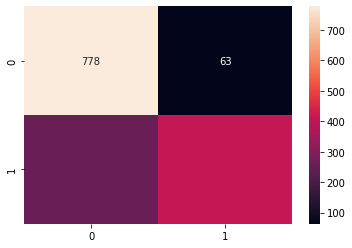

In [37]:
sns.heatmap(confusion_matrix(y_test,logr_y_pred), annot=True, fmt="d")

#### 2. Random Forest

In [38]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
rf_y_pred=rf.predict(X_test)
accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("Classification Report of Random Forest:\n", classification_report(y_test, rf_y_pred))

Accuracy: 0.7721
Classification Report of Random Forest:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82       841
           1       0.84      0.60      0.70       664

    accuracy                           0.77      1505
   macro avg       0.79      0.75      0.76      1505
weighted avg       0.78      0.77      0.76      1505



In [39]:
print('Training accuracy:', rf.score(X_train,y_train))
print('Test accuracy:', rf.score(X_test,y_test))

Training accuracy: 0.9971742021276596
Test accuracy: 0.772093023255814


<Axes: >

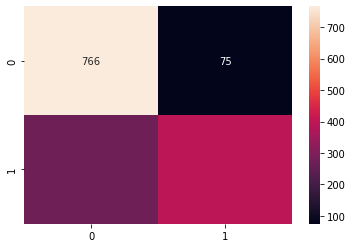

In [40]:
sns.heatmap(confusion_matrix(y_test,rf_y_pred), annot=True, fmt="d")

#### 3. Naive Bayes

In [41]:
nb=MultinomialNB()
nb.fit(X_train,y_train)
nb_y_pred=nb.predict(X_test)
accuracy = accuracy_score(y_test, nb_y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("Classification Report of Naive Bayes:\n", classification_report(y_test, logr_y_pred))

Accuracy: 0.7874
Classification Report of Naive Bayes:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       841
           1       0.87      0.61      0.72       664

    accuracy                           0.79      1505
   macro avg       0.81      0.77      0.77      1505
weighted avg       0.80      0.79      0.78      1505



In [42]:
print('Training accuracy:', nb.score(X_train,y_train))
print('Test accuracy:', nb.score(X_test,y_test))

Training accuracy: 0.9005984042553191
Test accuracy: 0.7873754152823921


<Axes: >

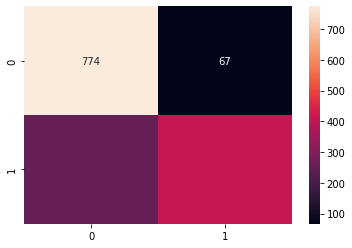

In [43]:
sns.heatmap(confusion_matrix(y_test,nb_y_pred), annot=True, fmt="d")

#### 4.SVC

In [44]:
svc=SVC()
svc.fit(X_train,y_train)
svc_y_pred=svc.predict(X_test)
accuracy = accuracy_score(y_test, svc_y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("Classification Report of SVC:\n", classification_report(y_test, svc_y_pred))

Accuracy: 0.7834
Classification Report of SVC:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83       841
           1       0.88      0.59      0.71       664

    accuracy                           0.78      1505
   macro avg       0.81      0.76      0.77      1505
weighted avg       0.80      0.78      0.77      1505



In [45]:
print('Training accuracy:', svc.score(X_train,y_train))
print('Test accuracy:', svc.score(X_test,y_test))

Training accuracy: 0.9720744680851063
Test accuracy: 0.7833887043189369


<Axes: >

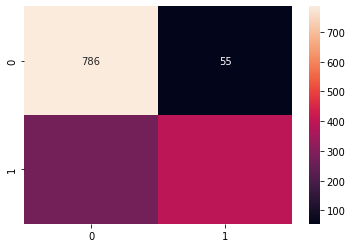

In [46]:
sns.heatmap(confusion_matrix(y_test,svc_y_pred), annot=True, fmt="d")

- Observation on Modeling:¶
1. we notice that there is an obvious Overfitting using all 4 ML Models,As all mosels have almost trainning accuracy between 97, 99 % and testing accuracy 79 %.

2. So I will apply Grid Search and Cross Validation to prevent Overfitting.

### Applying Grid Search to Reduce or Prevent Overfitting



#### 1. Grid Search on Logistic Regression

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
param_grid={'C':[0.001,0.01,0.1,1,10,100]}
grid_search_lr=GridSearchCV(log_r,param_grid,cv=5,scoring='accuracy')
grid_search_lr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [49]:
print(f"Best C: {grid_search_lr.best_params_['C']}")

Best C: 1


In [50]:
# Take the best model of logistic with the best parameter to calculate training,testing accuracy
best_model_lr=grid_search_lr.best_estimator_

# Training Accuracy
y_train_pred_lr=best_model_lr.predict(X_train)
trainning_accuracy_lr=accuracy_score(y_train,y_train_pred_lr)

# Testing Accuracy
y_test_pred_lr=best_model_lr.predict(X_test)
testing_accuracy_lr=accuracy_score(y_test,y_test_pred_lr)

print(f"Training Accuracy of Logistic Regression : {trainning_accuracy_lr * 100:.2f}")
print(f"Testing Accuracy  of Logistic Regression: {testing_accuracy_lr * 100:.2f}")

Training Accuracy of Logistic Regression : 88.96
Testing Accuracy  of Logistic Regression: 78.80


In [51]:
print("Classification Report  of Logistic Regression:\n", classification_report(y_test, y_test_pred_lr))

Classification Report  of Logistic Regression:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       841
           1       0.87      0.61      0.72       664

    accuracy                           0.79      1505
   macro avg       0.81      0.77      0.77      1505
weighted avg       0.80      0.79      0.78      1505



#### 2.Grid Search on Random Forest

In [52]:
param_grid={'n_estimators':[50,100,200],
            'max_depth':[5,10,20,None],
            'min_samples_split':[2,5,10,20]
           }
grid_search_rf=GridSearchCV(rf,param_grid,cv=5,scoring='accuracy')
grid_search_rf.fit(X_train,y_train)
print(" Best params of Random Forest: ",grid_search_rf.best_params_)

 Best params of Random Forest:  {'max_depth': None, 'min_samples_split': 20, 'n_estimators': 200}


In [53]:
# Take the best model of Random Forest with the best parameter to calculate training,testing accuracy
best_model_rf=grid_search_rf.best_estimator_

# Training Accuracy
y_train_pred_rf=best_model_rf.predict(X_train)
trainning_accuracy_rf=accuracy_score(y_train,y_train_pred_rf)

# Testing Accuracy
y_test_pred_rf=best_model_rf.predict(X_test)
testing_accuracy_rf=accuracy_score(y_test,y_test_pred_rf)

print(f"Training Accuracy of Random Forest : {trainning_accuracy_rf * 100:.2f}")
print(f"Testing Accuracy  of Random Forest : {testing_accuracy_rf * 100:.2f}")

Training Accuracy of Random Forest : 97.71
Testing Accuracy  of Random Forest : 78.14


In [54]:
print("Classification Report of Random Forest after Grid Search:\n",
      classification_report(y_test, y_test_pred_rf))

Classification Report of Random Forest after Grid Search:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82       841
           1       0.84      0.63      0.72       664

    accuracy                           0.78      1505
   macro avg       0.80      0.77      0.77      1505
weighted avg       0.79      0.78      0.78      1505



- Observation on Random Forest After Grid Search:

  1.Testing Accuracy improved 1% after applying Grid Search on Ravdom Forest.

 2. OverFitting still occurs.

#### 3.Grid Search on SVC

In [55]:
param_grid={
    'C':[0.001,0.01,0.1,1,10,],
    'class_weight': [None, 'balanced']
           }
grid_search_svc=GridSearchCV(svc,param_grid,cv=5,scoring='accuracy')
grid_search_svc.fit(X_train,y_train)
print(" Best params of SVC: ",grid_search_svc.best_params_)

 Best params of SVC:  {'C': 1, 'class_weight': 'balanced'}


In [56]:
# Take the best model of logistic with the best parameter to calculate training,testing accuracy
best_model_svc=grid_search_svc.best_estimator_

# Training Accuracy
y_train_pred_svc=best_model_svc.predict(X_train)
trainning_accuracy_svc=accuracy_score(y_train,y_train_pred_svc)

# Testing Accuracy
y_test_pred_svc=best_model_svc.predict(X_test)
testing_accuracy_svc=accuracy_score(y_test,y_test_pred_svc)

print(f"Training Accuracy of SVC : {trainning_accuracy_svc * 100:.2f}")
print(f"Testing Accuracy  of  SVC: {testing_accuracy_svc * 100:.2f}")

Training Accuracy of SVC : 98.02
Testing Accuracy  of  SVC: 79.14


In [57]:
print("Classification Report of SVC after Grid Search:\n",
      classification_report(y_test, y_test_pred_svc))

Classification Report of SVC after Grid Search:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83       841
           1       0.84      0.66      0.73       664

    accuracy                           0.79      1505
   macro avg       0.80      0.78      0.78      1505
weighted avg       0.80      0.79      0.79      1505



- Observation on SVC after Grid Search:

  1.Testing Accuracy improved 1% after applying Grid Search on Ravdom Forest.

2. OverFitting still occurs.

### Results

#### 1. Logistic Regression

- Training accuracy: 0.8896276595744681
- Test accuracy: 0.7880398671096346
    
#### Grid Search on Logistic Regression

- Training Accuracy of Logistic Regression : 88.96
- Testing Accuracy  of Logistic Regression: 78.80

#### 2. Random Forest

- Training accuracy: 0.9971742021276596
- Test accuracy: 0.772093023255814
    
#### Grid Search on Random Forest

- Training Accuracy of Random Forest : 97.71
- Testing Accuracy  of Random Forest : 78.14

#### 3. Naive Bayes

- Training accuracy: 0.9005984042553191
- Test accuracy: 0.7873754152823921
    

#### 4. SVC

- Training accuracy: 0.9720744680851063
- Test accuracy: 0.7833887043189369
    
#### Grid Search on SVC

- Training Accuracy of SVC : 98.02
- Testing Accuracy  of  SVC: 79.14